In [50]:
import re
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import nltk
from nltk.corpus import stopwords

from collections import Counter

### Загрузка датасетов

In [33]:
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'

In [37]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [4]:
train_df.head(5)

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      60000 non-null  int64 
 1   Review  60000 non-null  object
 2   Rating  60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


### Просмотр случайных примеров

In [6]:
def view_samples(df, count=5):
    idx = random.sample(train_df.index.to_list(), count)
    print('=========================================\n')
    for _ in idx:
        print(f'id:\t{df.Id[_]}\n')
        print(f'Review:\n{df.Review[_]}\n')
        print(f'Rating:\n{df.Rating[_]}')
        print('=========================================\n')

In [9]:
view_samples(train_df, count=3)


id:	49219

Review:
Quick payment, higher than others for paying too

Rating:
5

id:	59408

Review:
Staff nice to your face but fill you full of lies to get a sale. Now can't get refund cos it's company policy even though I haven't had any goods or service from them. Just sit and wait and report the transaction to Visa and trading standards. I was told I was confirming identity by chip and pin and no payment would be taken but was actually charged £170. Lesson learned don't shop with them again.

Rating:
1

id:	7463

Review:
Everything was explained clearly and the guy who served me was very approachable, friendly and helpful

Rating:
5



### Распределение данных

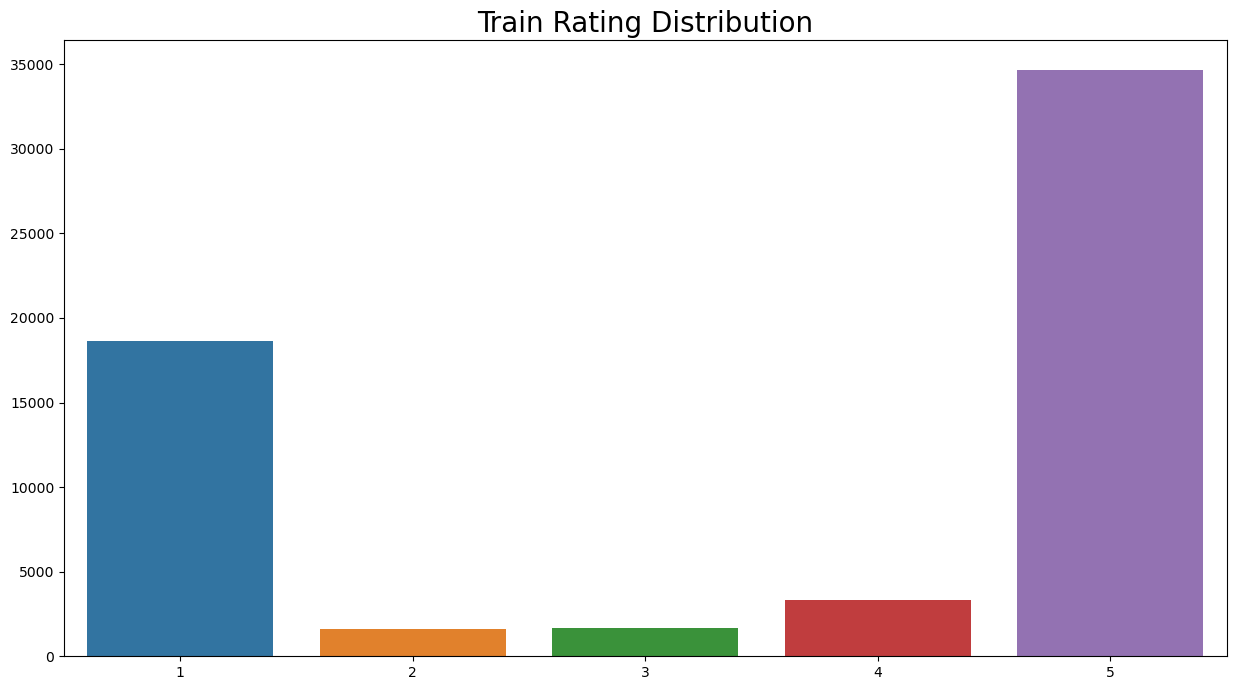

In [10]:
plt.figure(figsize=(15, 8))
plt.title('Train Rating Distribution', fontsize=20)

train_distribution = train_df['Rating'].value_counts().sort_values()
sns.barplot(x=list(train_distribution.keys()),
            y=train_distribution.values);

Набор данных несбалансирован по классам: большинство отзывов имеют рейтинг 1 или 5, что стоит учитывать при выборе модели.

### Длина отзывов

In [11]:
# Длина отзыва
train_df['review_length'] = [len(_) for _ in train_df.Review]

# Количество точенов в отзыве
train_df['token_count'] = [len(_.split()) for _ in train_df.Review]

In [12]:
train_df.head(5)

,Id,Review,Rating,review_length,token_count
0,0,Very good value and a great tv very happy and ...,5,89,18
1,1,After 6 month still can't access my account,3,43,8
2,2,I couldn't make an official review on a produc...,1,496,92
3,3,"Fantastic! Extremely easy to use website, fant...",5,197,32
4,4,So far annoyed as hell with this bt monthly pa...,1,222,49


In [13]:
print('Review Length Description')
print('==================================')
print(train_df['review_length'].describe())
print('==================================')

Review Length Description
count    60000.000000
mean       309.070083
std        423.772492
min         31.000000
25%         82.000000
50%        164.000000
75%        358.000000
max       7794.000000
Name: review_length, dtype: float64


In [14]:
print('Token Count Description')
print('==================================')
print(train_df['token_count'].describe())
print('==================================')

Token Count Description
count    60000.00000
mean        56.56325
std         79.35289
min          1.00000
25%         14.00000
50%         29.00000
75%         66.00000
max       1439.00000
Name: token_count, dtype: float64


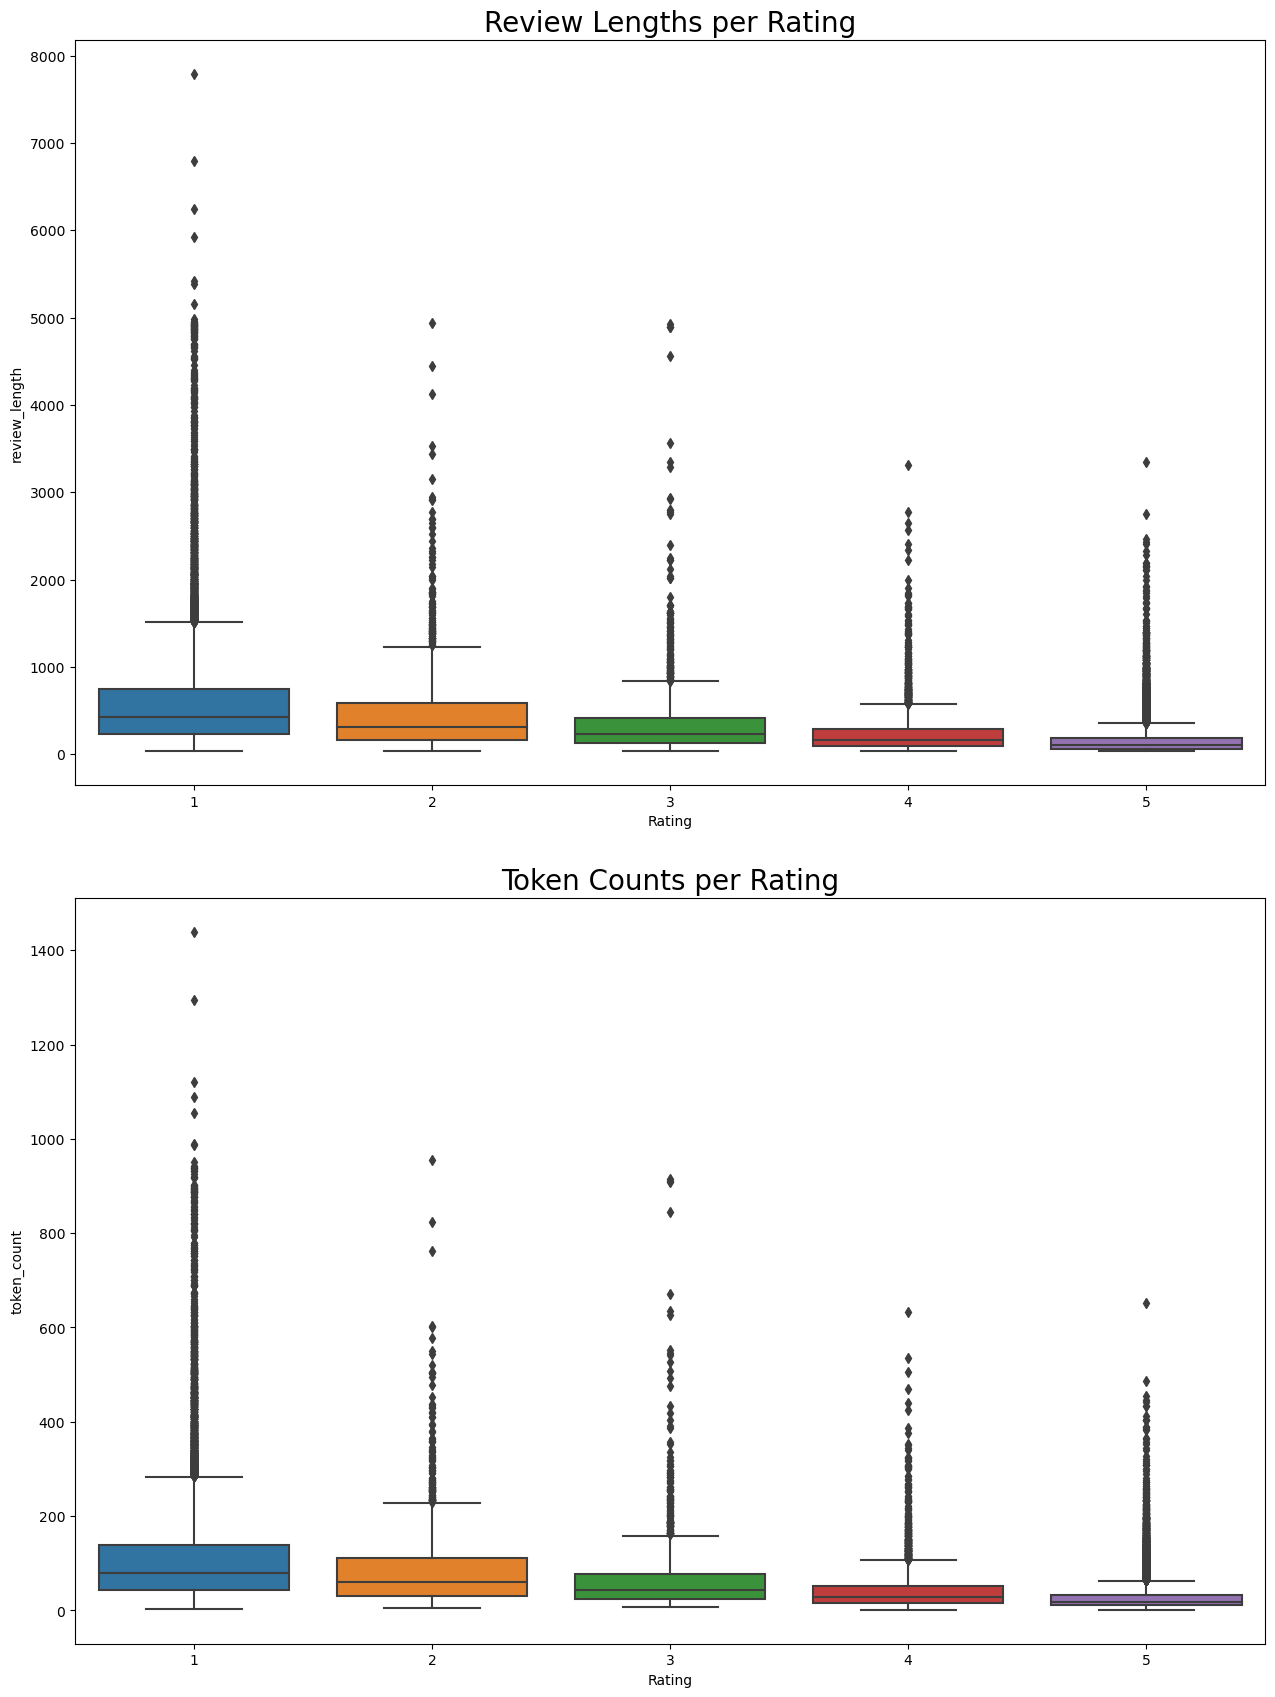

In [15]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 18))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Range of Review Lengths per Rating
ax1.set_title('Review Lengths per Rating', fontsize=20)
sns.boxplot(data=train_df, y='review_length', x='Rating',
            ax=ax1)

# Plot Range of Token Counts per Rating
ax2.set_title('Token Counts per Rating', fontsize=20)
sns.boxplot(data=train_df, y='token_count', x='Rating',
            ax=ax2);

Длина отзывов увеличивается по мере понижения рейтинга компании. То же наблюдение можно сделать и для количества токенов за отзыв. Причина этого может заключаться в том, что клиенты склонны подробно объяснять свое мнение, когда они недовольны компанииями/оказаннымии услугами, а когда клиент удовлетворен - отзывы имеют более высокие оценки и меньшее количество токенов и длину.

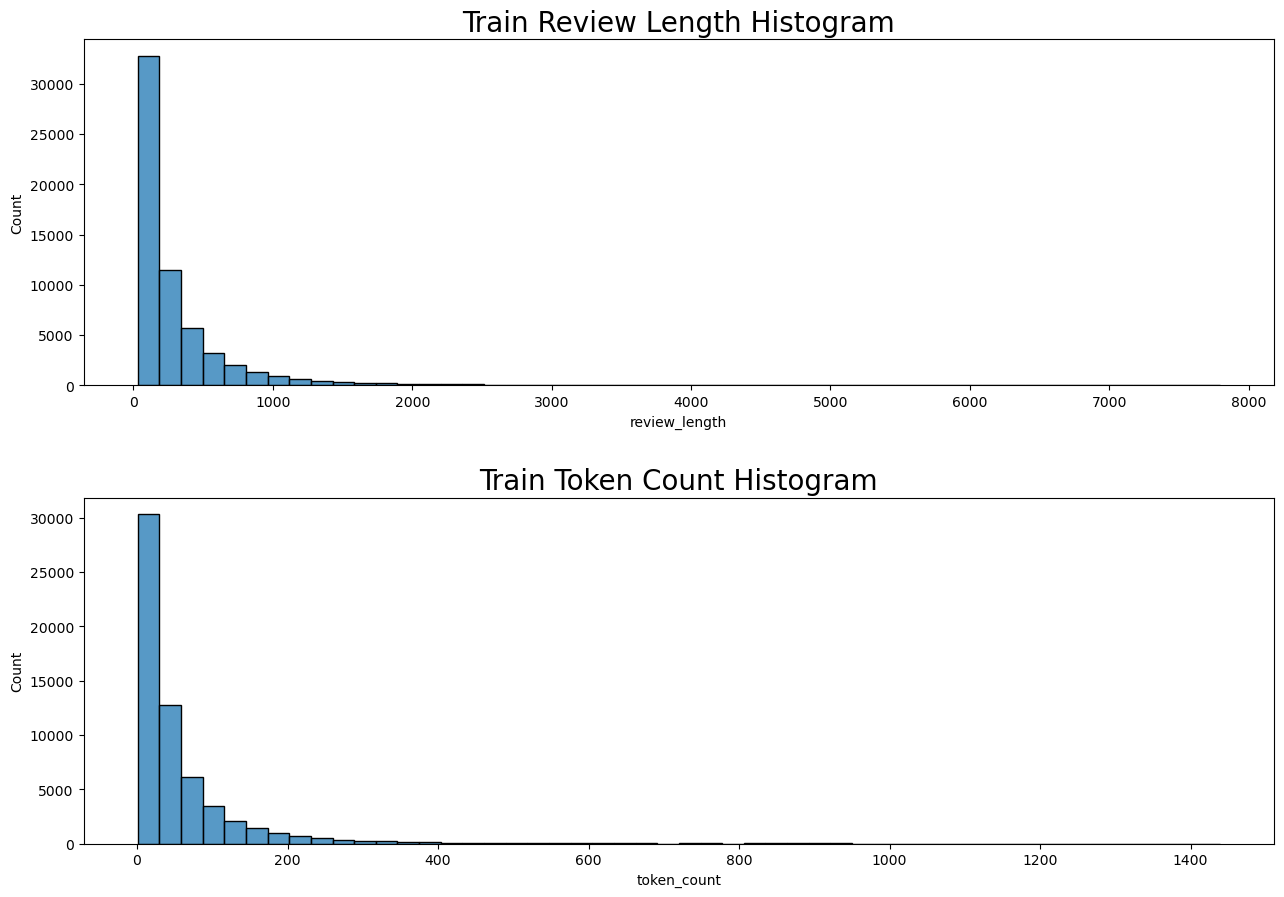

In [16]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Generate Train Rating Histogram
ax1.set_title('Train Review Length Histogram', fontsize=20)
sns.histplot(data=train_df, x='review_length', bins=50,
            ax=ax1)

# Generate Train Token Count Histogram
ax2.set_title('Train Token Count Histogram', fontsize=20)
sns.histplot(data=train_df, x='token_count', bins=50,
            ax=ax2);

Длина большинства отзывов не превышает ~1000, количество токенов не превышает ~300. Эти факторы следует учитывать при выборе количества токенов, которые будут использоваться в модели.

### Очистка данных

In [42]:
stopwords = stopwords.words("english")

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):    
    x = x.lower()
    x = removeHTML(x)
#     x = emoji.demojize(x, delimiters=(" ", " "))
    
    # left only important words
    words = re.findall(r'\w+', x,flags = re.UNICODE) 
    important_words = filter(lambda x: x not in stopwords, words)
    x = " ".join(important_words) 
    
    x = re.sub("@\w+", '',x) # removing mentions (@)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub(r"[^\w\s]", '',x) # to remove symbols
    x = re.sub("http\w+", '',x)
    x = re.sub("\s[a-z]\s", '',x)
    x = x.strip()
    return x

train_df["Review"] = train_df["Review"].apply(lambda x: dataPreprocessing(x))
test_df["Review"] = test_df["Review"].apply(lambda x: dataPreprocessing(x))

### Самые распространенные слова

In [43]:
r_1 = train_df[train_df['Rating']==1]
r_2 = train_df[train_df['Rating']==2]
r_3 = train_df[train_df['Rating']==3]
r_4 = train_df[train_df['Rating']==4]
r_5 = train_df[train_df['Rating']==5]

In [48]:
r_1['temp_list'] = r_1['Review'].apply(lambda x:str(x).split())
top = Counter([item for sublist in r_1['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

/var/folders/jj/tfmfz_tn2k7_wty3br1lyn1h0000gn/T/ipykernel_3696/996217725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_1['temp_list'] = r_1['Review'].apply(lambda x:str(x).split())


,Common_words,count
0,phone,11638
1,service,11356
2,customer,8830
3,would,8635
4,get,7864
5,told,7338
6,company,6642
7,still,6343
8,time,6229
9,back,6209


In [57]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words for Raiting 1', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [59]:
r_5['temp_list'] = r_5['Review'].apply(lambda x:str(x).split())
top = Counter([item for sublist in r_5['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Greens')

/var/folders/jj/tfmfz_tn2k7_wty3br1lyn1h0000gn/T/ipykernel_3696/3876576167.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Common_words,count
0,service,11903
1,delivery,11129
2,great,8677
3,good,7811
4,easy,6602
5,time,5310
6,excellent,5310
7,quick,4326
8,price,4017
9,helpful,3988


In [56]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words for Raiting 5', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()